# Layup Lines

Today, let's try running a KNN to predict survival of passengers on the Titanic.

Start by importing the usual, then read in the titanic dataset to a variable called "titanic_df"

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
titanic_df = pd.read_csv('titanic.csv')

Display some summary stats. Make a scatter plot with the Age and Fare columns

In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
titanic_df.head()

#sibsp = whether they had a sibling or spouse on the ticket
#parch = whether they had parents or children on the ticket

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


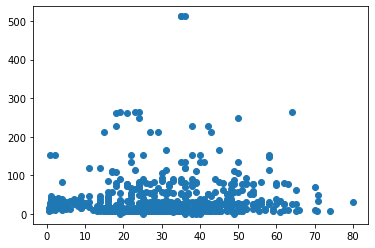

In [13]:
plt.scatter(titanic_df.Age, titanic_df.Fare)

Yikes! Looks like some 30somethings paid $512 dollars for their ticket. Hope they lived. 

Locate the row where the Fare column's value is $512. Create a markdown cell that answers "yes" or "no" to this question and maybe some analysis as to why.

Note that the exact value is "512.3292"

In [18]:
titanic_df[titanic_df.Fare == 512.3292]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


**Insert Analysis Here**....

<div class="alert-success">The three who paid $512 were in first class, they were relatively young, and only one of them was traveling with someone.</div class="alert-success">

Using the age, fare, and survived columns, let's predict whether someone would have survived. 

First off, you may have noticed that our Titanic Dataset contains quite a few NaNs. Let's just drop _all_ of those rows for this exercise

In [22]:
titanic_df = titanic_df.dropna()

In [23]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


Create a feature dataframe, X, with the "Age" and "Fare" columns and a target dataframe, y, with the "Survived" column

In [25]:
FEATURES = ['Age', 'Fare']

X = titanic_df[FEATURES]
y = titanic_df.Survived

Train/test/split our X and y. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Import KNN Classifier from sklearn's neighbor library

In [30]:
from sklearn.neighbors import KNeighborsClassifier

Instantiate the model

In [42]:
k_cl = KNeighborsClassifier()

Fit the model to the training data 

In [43]:
k_cl.fit(X_train, y_train)

KNeighborsClassifier()

In [55]:
k_cl.score(X_train, y_train)

0.7591240875912408

In [44]:
k_cl.score(X_test, y_test)

0.6304347826086957

What's the score of our model? Remember: you can use our instantiated model's built in score feature and feed it our X and y test variables

Let's run a prediction on our X_test data.

In [46]:
k_cl.predict(X_test)

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0], dtype=int64)

Now let's predict on some totally novel data! Let's pretend a passenger who was 45 years old and paid $30 was on the Titanic. Would they have survived?

In [48]:
alfred = [[45, 30]]

In [53]:
k_cl.predict(alfred)

array([0], dtype=int64)

## Dunk it!

Can you do all of the above after tuning hyperparameters with GridSearchCV?

In [54]:
from sklearn.model_selection import GridSearchCV